# NHITS generation

In [7]:
import pandas as pd

# Input file paths
hits_file = 'event000001000-hits.csv'
truth_file = 'event000001000-truth.csv'
particles_file = 'event000001000-particles.csv'

# Load the files
hits_df = pd.read_csv(hits_file)
truth_df = pd.read_csv(truth_file)
particles_df = pd.read_csv(particles_file)

# Compute nhits by grouping truth_df on particle_id
computed_nhits = truth_df.groupby('particle_id').size().reset_index(name='computed_nhits')

# Merge computed_nhits into particles_df
particles_with_nhits = pd.merge(
    particles_df,
    computed_nhits,
    on='particle_id',
    how='left'
)

# Fill missing values for particles with no hits
particles_with_nhits['computed_nhits'] = particles_with_nhits['computed_nhits'].fillna(0).astype(int)

# Compare computed nhits with existing nhits
comparison = particles_with_nhits[['particle_id', 'nhits', 'computed_nhits']]
discrepancies = comparison[comparison['nhits'] != comparison['computed_nhits']]

# Print summary
print("Total particles:", len(particles_df))
print("Total discrepancies found:", len(discrepancies))
print()

# Print discrepancies if any
if not discrepancies.empty:
    print("Discrepancies:")
    print(discrepancies)
else:
    print("✅ All nhits match between data and computed values.")

# Save comparison to a CSV (optional)
comparison.to_csv('particles_nhits_comparison.csv', index=False)
print("\nComparison saved as 'particles_nhits_comparison.csv'.")


Total particles: 12263
Total discrepancies found: 0

✅ All nhits match between data and computed values.

Comparison saved as 'particles_nhits_comparison.csv'.


In [23]:
import os
import glob
import pandas as pd
from tqdm.notebook import tqdm

# Set your data directory
data_dir = 'data/ttbar_H_production_p50/csv/background/processed_events/'

# Find all event*-particles.csv files
particles_files = sorted(glob.glob(os.path.join(data_dir, 'event*-particles.csv')))

for particles_file in tqdm(particles_files):
    print(f"Processing: {particles_file}")

    # Extract event ID from filename
    basename = os.path.basename(particles_file)
    event_id = basename.split('-')[0]

    # Construct corresponding truth file name
    truth_file = os.path.join(data_dir, f"{event_id}-truth.csv")

    if not os.path.exists(truth_file):
        print(f"Skipping {event_id}: truth file not found.")
        continue

    # Load files
    particles_df = pd.read_csv(particles_file)
    truth_df = pd.read_csv(truth_file)

    particles_df.drop(columns=['nhits'], inplace=True)

    # Compute nhits per particle_id from truth
    nhits_per_particle = (
        truth_df.groupby('particle_id').size().reset_index(name='nhits')
    )

    # Merge nhits into particles DataFrame
    particles_df = pd.merge(
        particles_df,
        nhits_per_particle,
        on='particle_id',
        how='left'
    )
    
    # Print columns after merge
    print(f"Columns after merge: {particles_df.columns.tolist()}")
    
    # Fill missing values for particles with no hits
    if 'nhits' in particles_df.columns:
        particles_df['nhits'] = particles_df['nhits'].fillna(0).astype(int)
    elif 'nhits_y' in particles_df.columns:
        # Use the merged column and drop the suffix column
        particles_df['nhits'] = particles_df['nhits_y'].fillna(0).astype(int)
        particles_df.drop(columns=['nhits_y'], inplace=True)
        particles_df.drop(columns=['nhits_x'], inplace=True)
    else:
        print(f"⚠️ Could not find 'nhits' column after merge for {particles_file} — skipping this file.")
        continue

    # Save the updated particles DataFrame (overwrite the file)
    particles_df.to_csv(particles_file, index=False)

    print(f"✅ Updated {particles_file} with nhits.")

print("\n🎉 All events processed!")


  0%|          | 0/10912 [00:00<?, ?it/s]

Processing: data/ttbar_H_production_p50/csv/background/processed_events/event000000002-particles.csv
Columns after merge: ['particle_id', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'q', 'nhits']

🎉 All events processed!


nhits distribution:
nhits
0     1897
1       17
2       67
3       14
4       73
5       22
6       67
7       31
8       87
9       82
10     230
11     378
12     492
13     382
14     241
15      96
16      44
17      21
18       1
Name: count, dtype: int64


[]

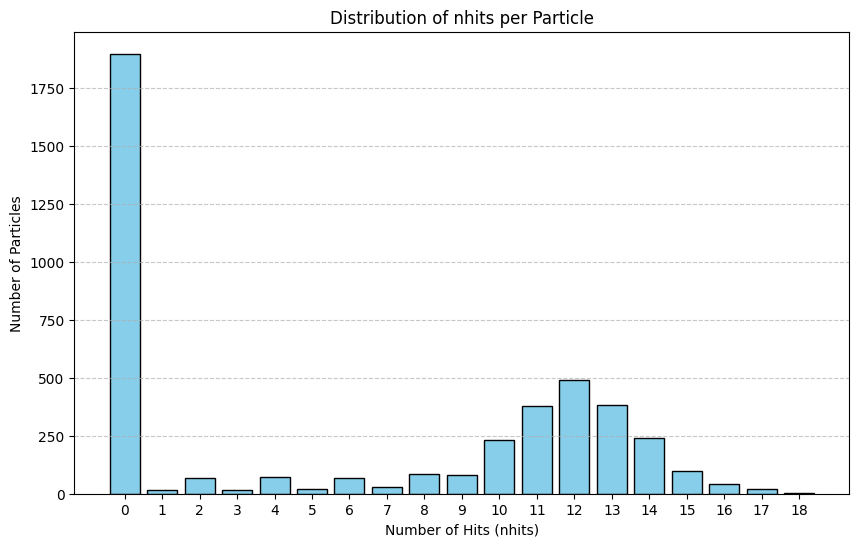

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the particles file
# particles_file = 'data/ttbar_H_production_p50/csv/background/tml_dataset/event000000002-particles.csv'  # Adjust this path
# particles_file = 'event000001000-particles.csv'
# Load particles DataFrame
particles_df = pd.read_csv(particles_file)

# Remove all q=0
particles_df = particles_df[particles_df['q'] != 0]

# Determine which nhits column to use
if 'nhits' in particles_df.columns:
    nhits_column = 'nhits'
elif 'nhits_y' in particles_df.columns:
    nhits_column = 'nhits_y'
elif 'nhits_x' in particles_df.columns:
    nhits_column = 'nhits_x'
else:
    raise ValueError("No 'nhits' column found in the particles file!")

# Count how many particles have 0, 1, 2, ... hits
nhits_counts = particles_df[nhits_column].value_counts().sort_index()

# Print counts to console
print("nhits distribution:")
print(nhits_counts)

# Plot the distribution
plt.figure(figsize=(10,6))
# plt.bar(nhits_counts.index[1:], nhits_counts.values[1:], width=0.8, color='skyblue', edgecolor='black')
plt.bar(nhits_counts.index, nhits_counts.values, width=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Number of Hits (nhits)')
plt.ylabel('Number of Particles')
plt.title('Distribution of nhits per Particle')
plt.xticks(nhits_counts.index)  # Ensure all bins are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.plot()

# Save the plot
# output_plot_file = 'nhits_distribution.png'
# plt.savefig(output_plot_file, dpi=300)
# plt.close()

# print(f"\nPlot saved as '{output_plot_file}'")


# Weight generation

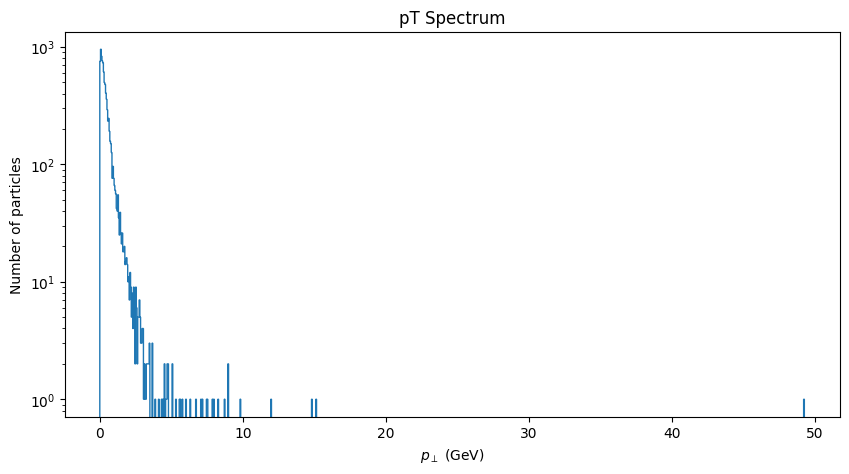

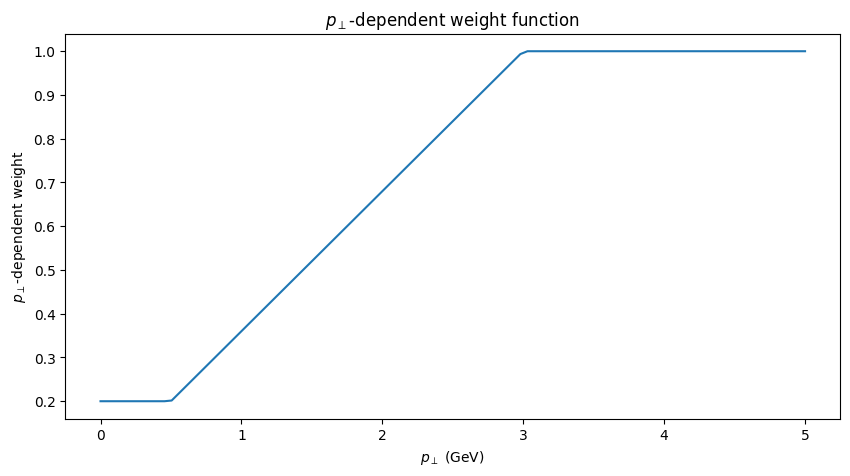

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
hits = pd.read_csv("data/ttbar_H_production_p50/csv/background/processed_events/event000000012-hits.csv")
particles = pd.read_csv("data/ttbar_H_production_p50/csv/background/processed_events/event000000012-particles.csv")
truth = pd.read_csv("data/ttbar_H_production_p50/csv/background/processed_events/event000000012-truth.csv")

# Calculate pT
particles["pT"] = np.sqrt(particles["px"]**2 + particles["py"]**2)

# Define pT-dependent weight function
def w_pT(pt):
    if pt < 0.5:
        return 0.2
    elif pt < 3:
        return 0.2 + 0.8 * (pt - 0.5) / (3 - 0.5)
    else:
        return 1.0

particles["w_pT"] = particles["pT"].apply(w_pT)

# Merge hits and truth for easy sorting
merged = truth.merge(hits, on="hit_id")
merged = merged.merge(particles[["particle_id", "pT", "w_pT"]], on="particle_id")

# Sort hits per particle by radius (optional: by z only for approximate ordering)
merged["r"] = np.sqrt(merged["x"]**2 + merged["y"]**2 + merged["z"]**2)
merged.sort_values(by=["particle_id", "r"], inplace=True)

# Assign order-dependent weights
def assign_order_weight(n_hits, order):
    if order == 0:
        return 1.0  # innermost
    elif order == n_hits - 1:
        return 1.0  # outermost
    elif order in [1, n_hits - 2]:
        return 0.7
    else:
        return 0.4

weights_order = []
for pid, group in merged.groupby("particle_id"):
    n_hits = len(group)
    for i, row in enumerate(group.itertuples()):
        weights_order.append(assign_order_weight(n_hits, i))

merged["w_order"] = weights_order

# Calculate total hit weight
merged["w_total"] = merged["w_order"] * merged["w_pT"]

# Normalize weights so that sum over all hits equals 1
normalization_factor = merged["w_total"].sum()
merged["w_total_normalized"] = merged["w_total"] / normalization_factor

# Save to CSV
merged.to_csv("truth_with_weights.csv", index=False)

max_pt = particles["pT"].max()
bin_width = 0.05  # 50 MeV in GeV
bins = np.arange(0, max_pt + bin_width, bin_width)

# Plotting

# 1. Plot pT distribution
plt.figure(figsize=(10,5))
plt.hist(particles["pT"], bins=bins, histtype='step', log=True)
plt.xlabel(r"$p_\perp$ (GeV)")
plt.ylabel("Number of particles")
plt.title("pT Spectrum")
plt.show()

# 2. Plot w_pT vs pT
pt_values = np.linspace(0, 5, 100)
weights = [w_pT(pt) for pt in pt_values]

plt.figure(figsize=(10,5))
plt.plot(pt_values, weights)
plt.xlabel(r"$p_\perp$ (GeV)")
plt.ylabel(r"$p_\perp$-dependent weight")
plt.title(r"$p_\perp$-dependent weight function")
plt.show()


In [4]:
merged.w_total_normalized.sum()

1.0

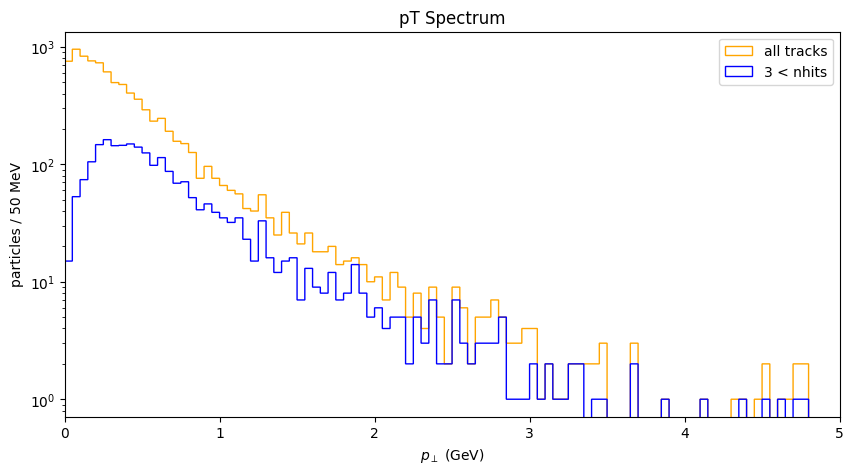

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load particles.csv
particles = pd.read_csv("data/ttbar_H_production_p50/csv/background/tml_dataset/event000000012-particles.csv")

# Calculate pT (assuming px and py are columns)
particles["pT"] = np.sqrt(particles["px"]**2 + particles["py"]**2)

# Define bin width and bin edges
bin_width = 0.05  # 50 MeV in GeV
# bin_width = 0.2  # 200 MeV in GeV
max_pt = particles["pT"].max()
bins = np.arange(0, max_pt + bin_width, bin_width)

# Plot the histogram
plt.figure(figsize=(10, 5))

# Plot all particles
plt.hist(particles["pT"], bins=bins, histtype='step', log=True, label="all tracks", color='orange')

# Plot particles with nhits >= 4
particles_4hits = particles[particles["nhits"] >= 4]
plt.hist(particles_4hits["pT"], bins=bins, histtype='step', log=True, label="3 < nhits", color='blue')

# Limit the x-axis to 0–5 GeV
plt.xlim(0, 5)

# Labeling
plt.xlabel(r"$p_\perp$ (GeV)")
plt.ylabel("particles / 50 MeV")
plt.title("pT Spectrum")
plt.legend()

plt.show()
